In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

import warnings

warnings.filterwarnings(action="ignore")


In [2]:
train = pd.read_csv('/data/ephemeral/data/train_data.csv')
test = pd.read_csv('/data/ephemeral/data/test_data.csv')

df = pd.concat([train, test])
df = df.reset_index(drop = True)

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df[df['answerCode'] != -1]

결론 

In [3]:
# 정답률에 유의미한 차이가 있는 month, weekday, hour에 대해 feature 추가 
df['month'] = df['Timestamp'].dt.month # 1~12 OX (11, 12에서 차이가 큼)
df['day'] = df['Timestamp'].dt.day # X 
df['weekday'] = df['Timestamp'].dt.weekday # 0~6 OX (토 ,일은 count가 특히 적음)
df['hour'] = df['Timestamp'].dt.hour # 0~23 O
df['min'] = df['Timestamp'].dt.minute # X

# assessmentItemID와 testId에 대한 대분류 feature 추가
df['first3'] = df['assessmentItemID'].apply(lambda x : x[2]).astype(int) # 010 ~ 090 O
df['mid3'] = df['assessmentItemID'].apply(lambda x : x[4:7]).astype(int) # 001~198 OX
df['last3'] = df['assessmentItemID'].apply(lambda x : x[-3:]).astype(int) # 문항 번호 X

In [4]:
def percentile(s):
    return np.sum(s) / len(s)

In [5]:
def graph_plot(df) : 
    fig, ax1 = plt.subplots()

    ax1.plot(df.index, df[df.columns[0]])
    ax1.set_ylabel(df.columns[0], color = 'blue')
    ax2 = ax1.twinx()
    ax2.plot(df.index, df[df.columns[1]], color = 'red')
    ax2.set_ylabel(df.columns[1], color = 'red')

    plt.show()

In [6]:
def graph_hist(df, str1, int1) : 
    fig, ax = plt.subplots()
    df[df['answerCode'] == 0][str1].hist(
        bins=int1, ax=ax, alpha=0.7, stacked=True, density=1, label = 'answer = 0'
    )
    df[df['answerCode'] == 1][str1].hist(
        bins=int1, ax=ax, alpha=0.7, stacked=True, density=1, label = 'answer = 1'
    )

    ax.legend()

testId, assessmentItemID에 대한 EDA

In [7]:
assess_first3 = df['assessmentItemID'].apply(lambda x : x[1:4]) # 1~9
assess_mid3 = df['assessmentItemID'].apply(lambda x : x[4:7])
assess_last3 = df['assessmentItemID'].apply(lambda x : x[-3:]) # 1~13

assess_mid3.value_counts()

assessmentItemID
017    20000
009    19550
011    19000
003    18900
007    18799
       ...  
180     4200
197     3295
194     2799
196     1449
198     1047
Name: count, Length: 198, dtype: int64

In [8]:
test_first3 = df['testId'].apply(lambda x : x[1:4]) # = assess_first3
test_mid3 = df['testId'].apply(lambda x : x[4:7]) # 0
test_last3 = df['testId'].apply(lambda x : x[-3:]) # = assess_mid3

test_last3.value_counts()

testId
017    20000
009    19550
011    19000
003    18900
007    18799
       ...  
180     4200
197     3295
194     2799
196     1449
198     1047
Name: count, Length: 198, dtype: int64

assessmentItemID = 문제 번호 = testId + 문항 번호 (3자리) = (first3 + mid3) + last3

각 3자리에 따른 정답률 변동..?

1 last3는 시험지 내 번호 => 정답률에 큰 변화는 없을 것이다. 

2 testId는 크게 first3 => mid3로 나뉜다 

2.1 first3는 학년? 과정? 등 큰 단위의 분류? => 9가지 분류

2.2 mid3는 과목, 단원 등 first3 내 작은 단위의 분류?

=> 198가지 분류, 전체적으로 모든 first3에 190개 이상씩 들어있음

=> 전체적으로 해당되는 분류...? 단원 번호 같은 느낌?

In [9]:
df.sample(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,month,day,weekday,hour,min,first3,mid3,last3
398328,546,A080067003,A080000067,1,2020-08-21 02:33:25,2869,8,21,4,2,33,8,67,3
731586,1059,A030036004,A030000036,1,2020-04-08 07:37:06,371,4,8,2,7,37,3,36,4
2477763,3345,A070118008,A070000118,0,2020-10-21 02:05:23,9592,10,21,2,2,5,7,118,8
1103825,1684,A020150004,A020000150,1,2020-09-07 11:08:50,8126,9,7,0,11,8,2,150,4
1181635,1837,A090028001,A090000028,0,2020-05-20 20:54:06,10181,5,20,2,20,54,9,28,1
397007,544,A080018004,A080000018,0,2020-03-23 17:35:17,4672,3,23,0,17,35,8,18,4
1905243,3750,A080001003,A080000001,1,2020-08-17 20:40:41,1396,8,17,0,20,40,8,1,3
550831,778,A020046002,A020000046,1,2020-07-28 11:14:00,7927,7,28,1,11,14,2,46,2
1476316,2476,A060105005,A060000105,0,2020-09-08 01:01:31,708,9,8,1,1,1,6,105,5
795445,1156,A050064004,A050000064,1,2020-01-14 05:11:14,3828,1,14,1,5,11,5,64,4


In [10]:
first3_groupby = df.groupby(["first3"]).agg(
    {
        "first3": "count",
        "answerCode": percentile,
    }
)

first3_groupby
# first3가 커질수록 전체적으로 정답률은 감소 

,first3,answerCode
first3,,
1,303675,0.801686
2,297263,0.738023
3,303365,0.702210
4,300403,0.680256
5,306317,0.659098
6,296284,0.712279
7,315177,0.521761
8,271841,0.500826
9,131631,0.454680


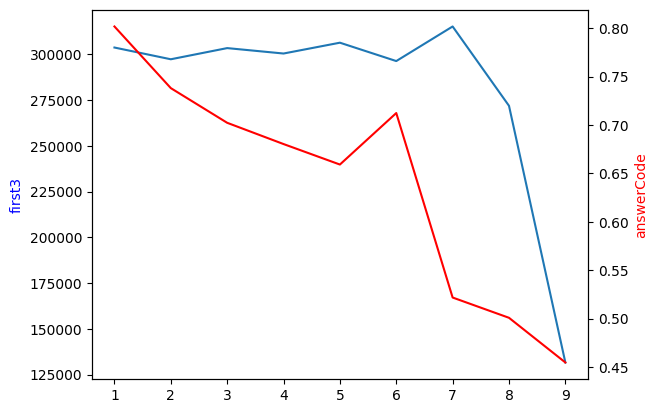

In [11]:
graph_plot(first3_groupby)

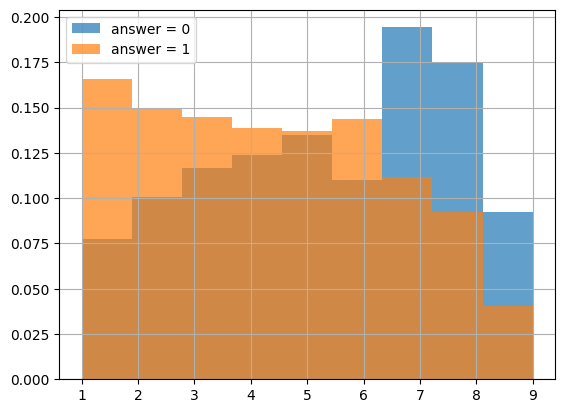

In [12]:
graph_hist(df, 'first3', len(first3_groupby))

In [13]:
mid3_groupby = df.groupby(["mid3"]).agg(
    {
        "mid3": "count",
        "answerCode": percentile,
    }
)

mid3_groupby
# mid3별 큰 정답률 차이는 없어보이나 특정 mid3에서 정답률 차이가 유의미함.

,mid3,answerCode
mid3,,
1,16750,0.708478
2,13900,0.777266
3,18900,0.627090
4,13700,0.683066
5,18200,0.620000
...,...,...
194,2799,0.688817
195,4846,0.836566
196,1449,0.890959


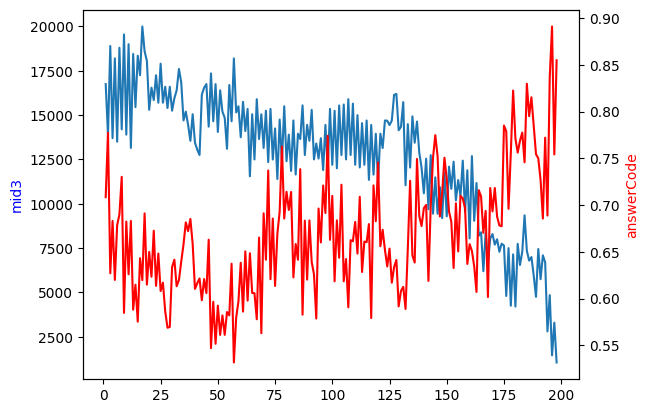

In [14]:
graph_plot(mid3_groupby)

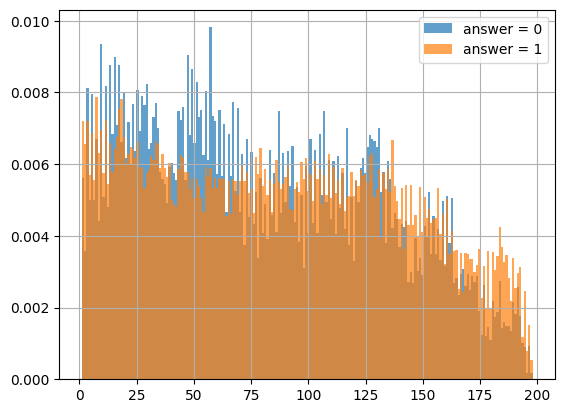

In [15]:
graph_hist(df, 'mid3', len(mid3_groupby))

In [16]:
mid3_groupby

,mid3,answerCode
mid3,,
1,16750,0.708478
2,13900,0.777266
3,18900,0.627090
4,13700,0.683066
5,18200,0.620000
...,...,...
194,2799,0.688817
195,4846,0.836566
196,1449,0.890959


Timestamp에 대한 EDA

In [17]:
year = df.groupby(df["Timestamp"].dt.year).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

year
# 년도에 따른 정답률은 신경쓰지 말자

,assessmentItemID,answerCode
Timestamp,,
2019,24,0.833333
2020,2525932,0.654637


In [18]:
month = df.groupby(df["Timestamp"].dt.month).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

month
# 월에 따른 차이가 특정 부분에서 크다 (11~12)

,assessmentItemID,answerCode
Timestamp,,
1,41777,0.706633
2,87957,0.686131
3,195207,0.681989
4,197461,0.650392
5,204474,0.643466
6,253480,0.652225
7,302116,0.666357
8,353517,0.657521
9,376980,0.670192


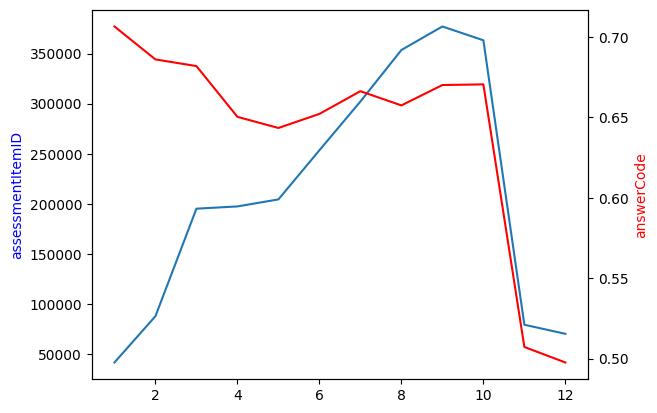

In [19]:
graph_plot(month)

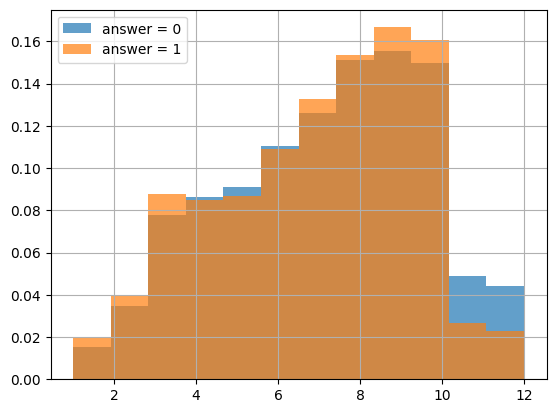

In [20]:
graph_hist(df, 'month', len(month))

In [21]:
day = df.groupby(df["Timestamp"].dt.day).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

day
# 일자에 따른 차이가 별로 없다

,assessmentItemID,answerCode
Timestamp,,
1,60794,0.651347
2,69511,0.657436
3,79255,0.654962
4,74038,0.644669
5,66774,0.645326
6,80537,0.665483
7,87845,0.662667
8,82612,0.659323
9,76111,0.658183


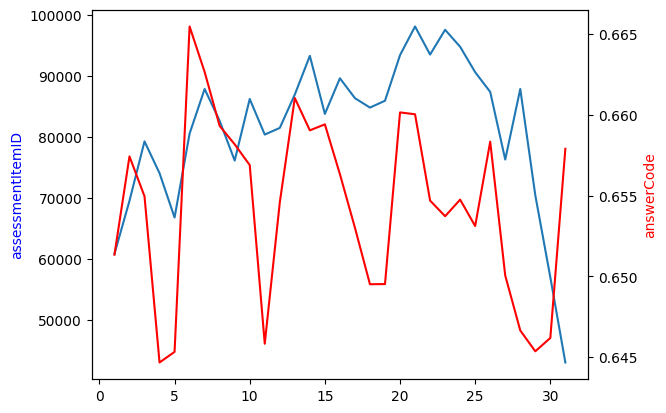

In [22]:
graph_plot(day)

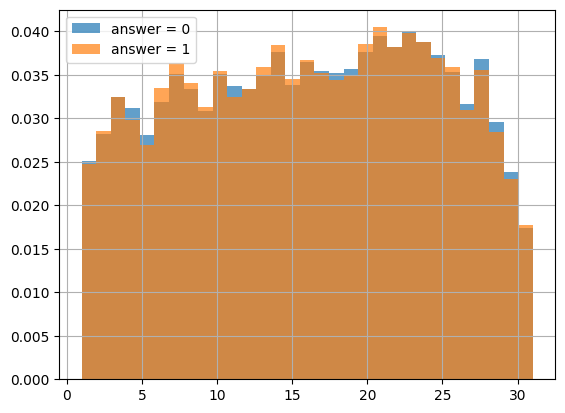

In [23]:
graph_hist(df, 'day', len(day))

In [24]:
weekday = df.groupby(df["Timestamp"].dt.weekday).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

weekday
# 요일에 따른 변화는 있어 보인다. => count에 의한 차이?

,assessmentItemID,answerCode
Timestamp,,
0,356298,0.676815
1,510649,0.667339
2,422897,0.641419
3,494393,0.658284
4,431259,0.644207
5,174142,0.603829
6,136318,0.674797


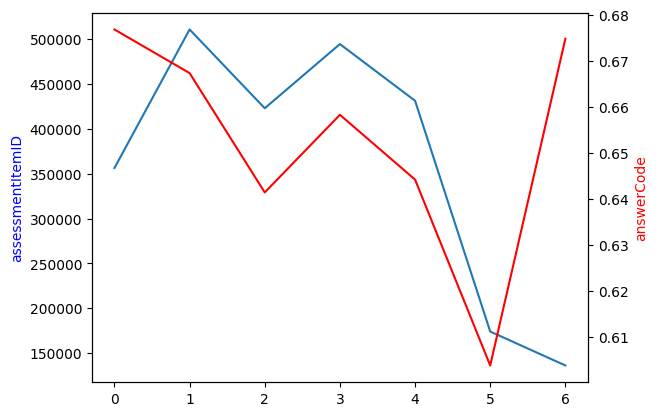

In [25]:
graph_plot(weekday)

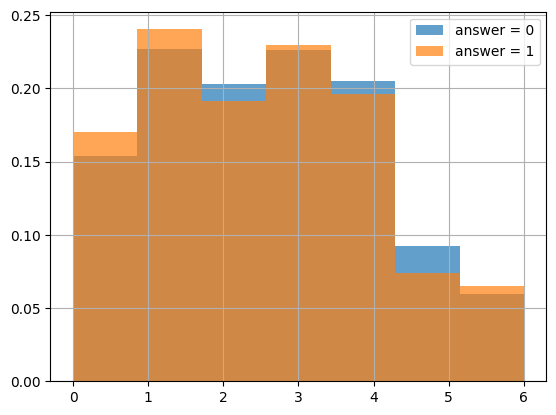

In [26]:
graph_hist(df, 'weekday', len(weekday))

In [27]:
hour = df.groupby(df["Timestamp"].dt.hour).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

hour
# 시간대 별 정답률의 차이가 있어보임

,assessmentItemID,answerCode
Timestamp,,
0,112534,0.650799
1,153201,0.645166
2,176301,0.642481
3,159012,0.633688
4,166390,0.633794
5,182771,0.625137
6,186350,0.628854
7,184683,0.642030
8,175761,0.670046


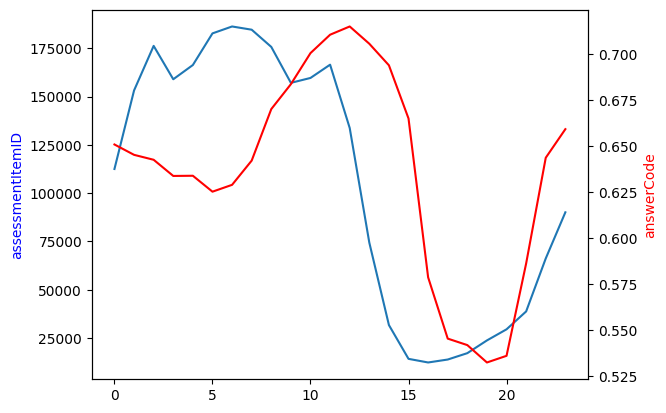

In [28]:
graph_plot(hour)

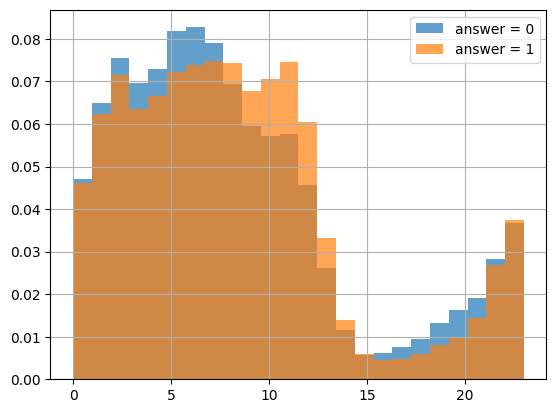

In [29]:
graph_hist(df, 'hour', len(hour))

In [30]:
min = df.groupby(df["Timestamp"].dt.minute).agg(
    {
        "assessmentItemID": "count",
        "answerCode": percentile,
    }
)

min
# 풀었던 분에 따른 정답률의 차이가 없어보임, 초도 마찬가지 

,assessmentItemID,answerCode
Timestamp,,
0,41240,0.651794
1,40817,0.657569
2,41439,0.650160
3,41562,0.651172
4,41475,0.656878
5,41337,0.656676
6,41277,0.660271
7,41974,0.649497
8,41945,0.656669


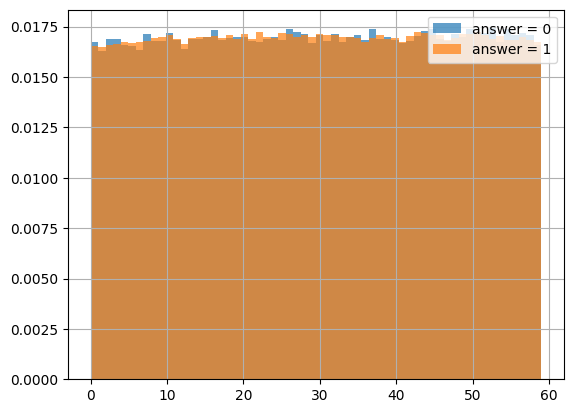

In [31]:
graph_hist(df, 'min', len(min))

KnowledageTag에 대한 EDA

<Axes: xlabel='KnowledgeTag', ylabel='answerCode'>

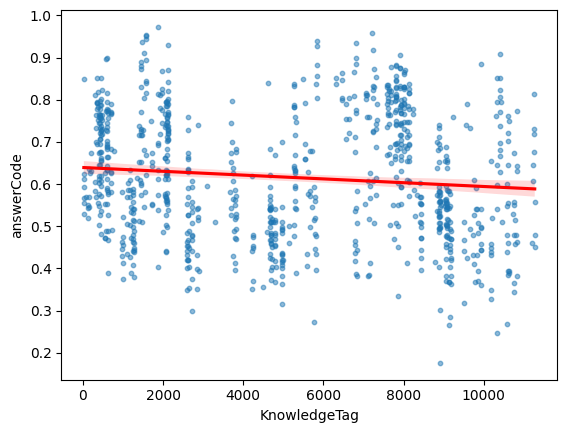

In [32]:
tag_groupby = df[df['answerCode'] != -1].groupby(['KnowledgeTag']).agg({
    'KnowledgeTag' : 'count',
    'answerCode' : percentile
})

sns.regplot(
    tag_groupby, 
    x = tag_groupby.index,
    y = "answerCode",
    scatter_kws={
        's':10,
        'alpha':0.5,
    },
    line_kws={'color':'r'}
)

# Tag에 따라 정답률의 차이는 있음
# 추가적인 FE가 필요할 것 같음 => user가 푼 Tag간 정답률의 차이..?

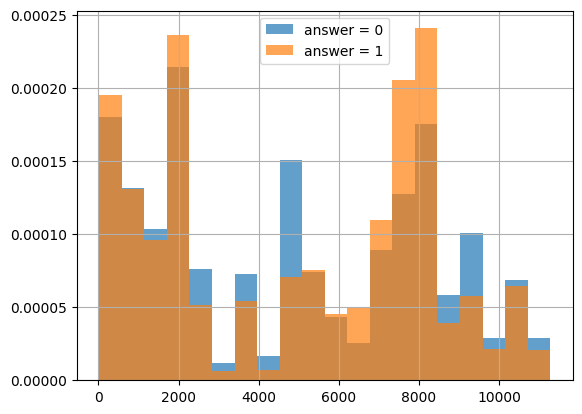

In [33]:
graph_hist(df, 'KnowledgeTag', 20)